In [2]:
import os
import findspark
findspark.init() # findspark sekarang sudah terinstal, jadi ini akan berhasil!

from pyspark.sql import SparkSession

os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

spark = SparkSession.builder \
    .appName("BigDataPractice") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

print("Spark success!")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/23 08:52:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark success!


In [3]:
data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()


+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



In [5]:
spark.sql('''
SELECT Gender, Age, SUM(Salary) AS TotalSalary
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()


+------+---+-----------+
|Gender|Age|TotalSalary|
+------+---+-----------+
|     M| 23|       2700|
|     F| 28|       4100|
|     M| 34|       3000|
+------+---+-----------+



In [6]:
spark.sql('''
SELECT DeptId, AVG(Salary) AS AvgSalary
FROM employees
GROUP BY DeptId
ORDER BY DeptId
''').show()


+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     1|   2850.0|
|     2|   4100.0|
+------+---------+



In [7]:
spark.sql('''
WITH avg_gender AS (
    SELECT Gender, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY Gender
)
SELECT e.Name, e.Gender, e.Salary, g.AvgSalary
FROM employees e
JOIN avg_gender g ON e.Gender = g.Gender
WHERE e.Salary > g.AvgSalary
''').show()


+-----+------+------+---------+
| Name|Gender|Salary|AvgSalary|
+-----+------+------+---------+
|James|     M|  3000|   2850.0|
+-----+------+------+---------+



In [8]:
spark.sql('''
SELECT 
    Name, DeptId, Salary,
    RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS RankInDept
FROM employees
''').show()


+-----+------+------+----------+
| Name|DeptId|Salary|RankInDept|
+-----+------+------+----------+
|James|     1|  3000|         1|
|  Lee|     1|  2700|         2|
| Anna|     2|  4100|         1|
+-----+------+------+----------+



In [9]:
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()


+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



In [11]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

25/10/23 09:12:45 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+



In [12]:
spark.sql('''
SELECT 
    e.Name,
    e.DeptId,
    d.DeptName,
    e.Salary,
    AVG(e.Salary) OVER (PARTITION BY e.DeptId) AS AvgDeptSalary,
    RANK() OVER (PARTITION BY e.DeptId ORDER BY e.Salary DESC) AS RankInDept
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
ORDER BY e.DeptId, RankInDept
''').show()


+-----+------+---------+------+-------------+----------+
| Name|DeptId| DeptName|Salary|AvgDeptSalary|RankInDept|
+-----+------+---------+------+-------------+----------+
|James|     1|       HR|  3000|       2850.0|         1|
|  Lee|     1|       HR|  2700|       2850.0|         2|
| Anna|     2|Marketing|  4100|       4100.0|         1|
+-----+------+---------+------+-------------+----------+



In [13]:
spark.sql('''
SELECT
    e.Name,
    e.DeptId,
    d.DeptName,
    e.Age,
    e.Salary,
    LAG(e.Salary) OVER (PARTITION BY e.DeptId ORDER BY e.Age) AS PrevSalary,
    (e.Salary - LAG(e.Salary) OVER (PARTITION BY e.DeptId ORDER BY e.Age)) AS SalaryChange
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
ORDER BY e.DeptId, e.Age
''').show()


+-----+------+---------+---+------+----------+------------+
| Name|DeptId| DeptName|Age|Salary|PrevSalary|SalaryChange|
+-----+------+---------+---+------+----------+------------+
|  Lee|     1|       HR| 23|  2700|      NULL|        NULL|
|James|     1|       HR| 34|  3000|      2700|         300|
| Anna|     2|Marketing| 28|  4100|      NULL|        NULL|
+-----+------+---------+---+------+----------+------------+



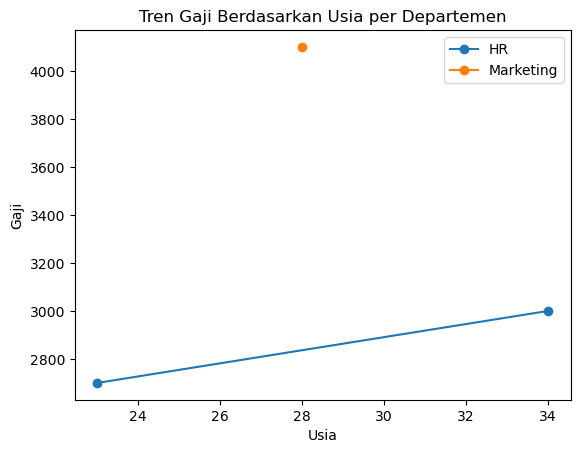

In [17]:
#Tambahan
df_trend = spark.sql('''
SELECT e.Age, e.Salary, d.DeptName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
''').toPandas()

import matplotlib.pyplot as plt
for dept in df_trend['DeptName'].unique():
    subset = df_trend[df_trend['DeptName'] == dept]
    plt.plot(subset['Age'], subset['Salary'], marker='o', label=dept)

plt.title("Tren Gaji Berdasarkan Usia per Departemen")
plt.xlabel("Usia")
plt.ylabel("Gaji")
plt.legend()
plt.show()


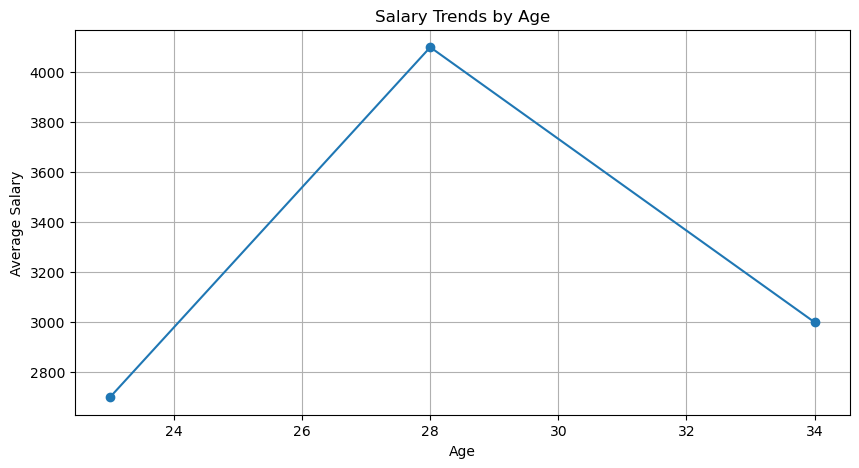

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()
